<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AdaBoost-模型" data-toc-modified-id="AdaBoost-模型-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AdaBoost 模型</a></span><ul class="toc-item"><li><span><a href="#构造数据" data-toc-modified-id="构造数据-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>构造数据</a></span></li><li><span><a href="#训练模型并可视化" data-toc-modified-id="训练模型并可视化-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>训练模型并可视化</a></span></li></ul></li><li><span><a href="#参考文献" data-toc-modified-id="参考文献-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>参考文献</a></span></li></ul></div>

# AdaBoost 模型

![title](boosting.gif)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons, make_circles
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [2]:
class Adaboost_Demonstration:
    def __init__(self, X, y, learning_rate=1.):
        self.X = X
        self.y = y
        # 给每个弱分类器一个衰减, 避免过拟合
        self.learning_rate = learning_rate
        # 样本的个数
        self.num_samples = len(self.X)
        # 初始化数据样本的权重
        self.sample_weight = np.full(self.num_samples, 1 / self.num_samples)
        # python list用来存储所有的弱分类器对象
        self.classifiers = []
        # 储存在每一步的错误率
        self.errors_list = []
        # 定义弱分类器, 这里我们直接调用sklearn的决策树, max_depth=1代表着这是一个一层决策树, 也就是决策树桩
        self.alphas = []
        
    def predict(self, data=None, label=None, reduction="sign"):
        if data is None:
            data = self.X
            label = self.y
            
        predictions = np.zeros([len(data)]).astype("float")
        for classifier, alpha in zip(self.classifiers, self.alphas):
            predictions += alpha * classifier.predict(data)
        if reduction == "sign":
            predictions = np.sign(predictions)
        elif reduction == "mean":
            predictions = predictions/len(self.classifiers)
        if label is not None and reduction == "sign":
            f1 = f1_score(predictions, label)
            return predictions, f1
        else:
            return predictions
        
    def contour_plot(self, data=None, labels=None, interval=0.2, title="AdaBoosr", mode="3d"):
        '''
        绘图部分
        '''
        if data == None:
            data = self.X
            labels = self.y
        if labels is None:
            labels = np.ones([len(data)])
        x_min, x_max = data[:, 0].min()-0.5, data[:, 0].max()+0.5
        y_min, y_max = data[:, 1].min()-0.5, data[:, 1].max()+0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, interval), np.arange(y_min, y_max, interval))
        # 将网格的X, Y轴拼接用来进行等高线的计算
        x_grid = np.concatenate([np.expand_dims(np.ravel(xx), axis=-1),
                                 np.expand_dims(np.ravel(yy), axis=-1)], axis=-1)
        z_grid = self.predict(data=x_grid, reduction="mean")
        z_grid = z_grid.reshape(xx.shape)
            
        if mode=="3d":
            scatter = go.Scatter3d(x=data[:, 0], y=data[:, 1], 
                                   z=self.predict(data=data, reduction="mean"),
                                   mode='markers',
                                   marker=dict(color=labels, size=5, symbol='circle',
                                               line=dict(color='rgb(204, 204, 204)', width=1),
                                               opacity=0.9))
            surface = go.Surface(x=xx, y=yy, z=z_grid, opacity=0.9)
            plot_data = [scatter, surface]
            layout = go.Layout(title=title)
            # 设置视角
            camera = dict(up=dict(x=0, y=0, z=1),
                          center=dict(x=0, y=0, z=0),
                          eye=dict(x=1, y=1, z=0.8))
            fig = go.Figure(data=plot_data, layout=layout)
            fig['layout'].update(scene=dict(camera=camera))
            iplot(fig, image="png", filename=title)
        if mode == "2d":
            # 等高线
            plt.contourf(xx, yy, Z_grid, cmap=plt.cm.RdBu, alpha=.8)
            # 散点
            plt.scatter(data[:, 0], data[:, 1], c=labels,
                        cmap=ListedColormap(['#FF0000', '#0000FF']), edgecolors='k')
            plt.title(title)
            plt.show()
            
    def __next__(self, reduction="mean", plot=True, plot_mode="2d"):
        classifier = DecisionTreeClassifier(max_depth=1)
        # 用弱分类器拟合数据
        classifier.fit(self.X, self.y, sample_weight=self.sample_weight)
        # 得到弱分类器对数据的推断, 也就是h(x)
        predictions = classifier.predict(self.X)
        # 计算错误率
        error_rate = np.mean(np.average((predictions != self.y), weights=self.sample_weight))
        # 计算alpha
        alpha = self.learning_rate * (np.log((1 - error_rate) / error_rate)) / 2
        # 计算t+1的权重
        self.sample_weight *= np.exp(-alpha * self.y * predictions)
        # 归一化, 归一化因子为Z: sum(self.sample_weight)
        self.sample_weight /= np.sum(self.sample_weight)
        # 记录当前弱分类器对象
        self.classifiers.append(classifier)
        # 记录当前弱分类器权重
        self.alphas.append(alpha)
        # 计算f1 score
        _, f1 = self.predict()
        # 画图
        if plot:
            return self.contour_plot(title="adaboost step " + str(len(self.classifiers)) + " f1 score: {:.2f}".format(f1), mode=plot_mode)
        else:
            return f1

## 构造数据

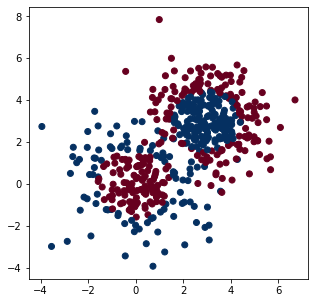

In [3]:
from sklearn.datasets import make_gaussian_quantiles
# 画两个正态分布的群
X1, y1 = make_gaussian_quantiles(cov=2.,
                                 n_samples=200, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=300, n_features=2,
                                 n_classes=2, random_state=1)
X=np.concatenate([X1,X2])
y=np.concatenate([y1,1-y2])
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)
y[np.where(y == 0)] =-1.5

## 训练模型并可视化

In [4]:
ada = Adaboost_Demonstration(X, y)

In [7]:
# 每次运行__next__函数, 都会新增加一个弱分类器, 并对当前的强分类器的分类边界进行可视化
'''
不要循环运行！！！！电脑容易死机！！！
'''
ada.__next__(plot=True, plot_mode="3d")

# 参考文献
[1] https://blog.csdn.net/asialee_bird/article/details/81051281?utm_source=app 

[2] 《统计学习方法》第 2 版，李航 

[3] https://zhuanlan.zhihu.com/p/67585925

[4] https://www.jianshu.com/p/514c07465a9e

[5] https://blog.csdn.net/hecongqing/article/details/104604111